In [1]:
import numpy as np
import serpentine as sp
from matplotlib import pyplot as plt
import cooler

Load data and perform a subsampling on the whole matrix

13833745.0
32042610.0
13833735.0
13833735.0
13363134
13363134


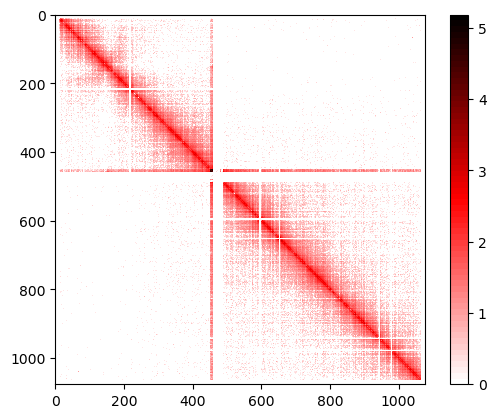

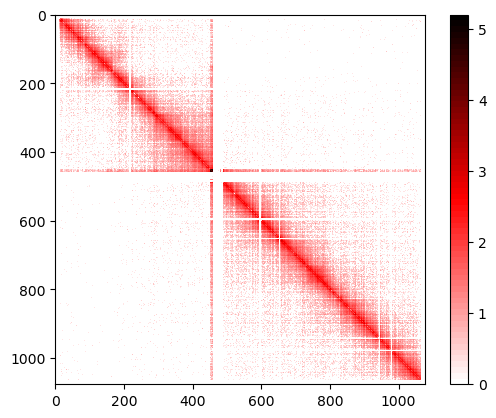

In [29]:
#you need to load your datasets with numpy
input_dir = "/mnt/e/Science/HiC/Contact_files/Dense/S288c/"
out_dir = "/mnt/d/Science/OwnCloud/Experiments/HiC/Serpentine/DSB/"
dir_seqs= "/mnt/d/Science/OwnCloud/Sequences/Genomes/"

inputA = "AD182_S288c_DSB_chr3_rDNA_cutsite_q20" #write sample name A here e.g. AP47
#inputA = "AD337_S288c_DSB_cutsite_q20"
inputB = "AD24_AD95_AD96_AD97_AD161_AD392to400_merged_S288c_DSB_chr3_rDNA_cutsite_q20"

chrom = "chr12" #chromosome number e.g. chr5
#DSB_pos = 777810 #chr4-765kb
#DSB_pos = 845464 #chr5 S288c_DSB
#for W303 chr5 DSB_pos=117000
#for S288c_DSB chr5 DSB_pos=118700
#for W303 chr4 DSB_pos=848500
#for S288c chr4 DSB_pos=845464

nA = np.loadtxt(str(input_dir + inputA + "_" + str(chrom) + "_dense_1kb.mat.csv"), dtype=np.float64)
nB = np.loadtxt(str(input_dir + inputB + "_" + str(chrom) + "_dense_1kb.mat.csv"), dtype=np.float64)
#chrs = pd.read_csv(str(dir_seqs + "Yeast_genome_W303_Marcand/W303_710_chromosome_centromere_coordinates.tsv"), sep = "\t")



#anchor_bin = DSB_pos/1000
#bin_nb = 30 #length in bins to use for normalization
#bins = np.arange(-bin_nb, bin_nb+1, 1)        
#anchor_bin = int(frags[(frags["chrom"]== chrom) & (frags["start_pos"] < DSB_pos) & (frags["end_pos"] >= DSB_pos)].index.values)

#subsampling chr 5=576 chr4=1531 chr3=316
bins=len(sum(nA))
print(sum(sum(nA[:,0:bins])))
print(sum(sum(nB[:,0:bins])))

for i in range(0,bins):
    a=np.array(nA[:,i], dtype="int64")
    b=np.array(nB[:,i], dtype="int64")
    target = min(sum(a), sum(b))
    #print(sum(a))
    #print(sum(b))
    if sum(a)>sum(b):
        a_idx = np.array([i for i in range(len(a))])
        a_idx = np.repeat(np.arange(len(a)), a)
        a_sub_idx = np.random.permutation(a_idx)[:target]
        a_sub_idx, a_sub_vals = np.unique(a_sub_idx, return_counts=True)
        a_sub = np.zeros(a.shape)
        a_sub[a_sub_idx] = a_sub_vals
        #print(a_sub)
        #print(int(sum(a_sub)))
        nA[:,i]=a_sub
    else:
        b_idx = np.array([i for i in range(len(b))])
        b_idx = np.repeat(np.arange(len(b)), b)
        b_sub_idx = np.random.permutation(b_idx)[:target]
        b_sub_idx, b_sub_vals = np.unique(b_sub_idx, return_counts=True)
        b_sub = np.zeros(b.shape)
        b_sub[b_sub_idx] = b_sub_vals
        #print(b_sub)
        #print(int(sum(b_sub)))
        nB[:,i]=b_sub

print(sum(sum(nA)))
print(sum(sum(nB)))

for i in range(0,bins):
    a=np.array(nA[i,:], dtype="int64")
    b=np.array(nB[i,:], dtype="int64")
    target = min(sum(a), sum(b))
    #print(sum(a))
    #print(sum(b))
    if sum(a)>sum(b):
        a_idx = np.array([i for i in range(len(a))])
        a_idx = np.repeat(np.arange(len(a)), a)
        a_sub_idx = np.random.permutation(a_idx)[:target]
        a_sub_idx, a_sub_vals = np.unique(a_sub_idx, return_counts=True)
        a_sub = np.zeros(a.shape)
        a_sub[a_sub_idx] = a_sub_vals
        #print(a_sub)
        #print(int(sum(a_sub)))
        nA[i,:]=a_sub
    else:
        b_idx = np.array([i for i in range(len(b))])
        b_idx = np.repeat(np.arange(len(b)), b)
        b_sub_idx = np.random.permutation(b_idx)[:target]
        b_sub_idx, b_sub_vals = np.unique(b_sub_idx, return_counts=True)
        b_sub = np.zeros(b.shape)
        b_sub[b_sub_idx] = b_sub_vals
        #print(b_sub)
        #print(int(sum(b_sub)))
        nB[i,:]=b_sub
        
        
A = np.array(nA, dtype="int64")
B = np.array(nB, dtype="int64")

print(sum(sum(A[:,0:bins])))
print(sum(sum(B[:,0:bins])))

        
fig = plt.figure()
sp.mshow(A)
fig = plt.figure()
sp.mshow(B)


Select only the chr12 part on the left of the rDNA

TypeError: 'int' object is not iterable

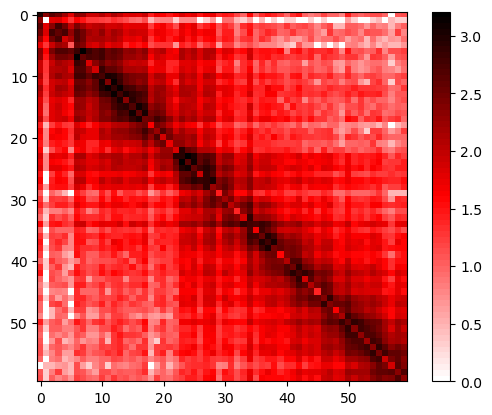

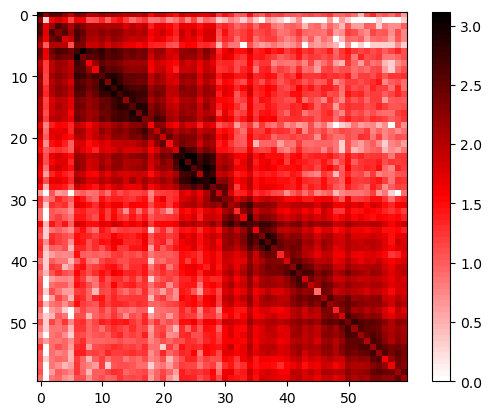

In [30]:

#rDNA coordinates = 450
start = 261
stop = 321
A=A[start:stop,start:stop]
B=B[start:stop,start:stop]


fig = plt.figure()
sp.mshow(A)
fig = plt.figure()
sp.mshow(B)
print(sum(sum(A[start:stop,:])))

Optional: remove certain bins (eg HO that creates artefact on chrIV)

0


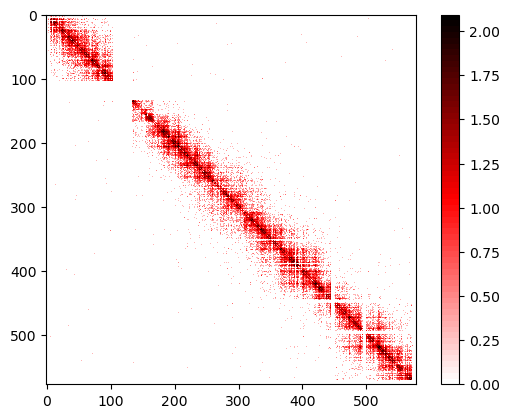

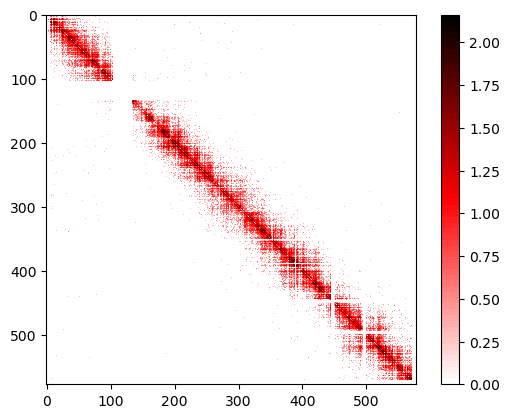

In [4]:
#HO coordinates = chrIV:46271..48031 -> bins 45-48
#rDNA and extra repeats is ~450-491
start = 105
stop = 135
A[start:stop,:] = 0
A[:,start:stop] = 0
B[start:stop,:] = 0
B[:,start:stop] = 0




fig = plt.figure()
sp.mshow(A)
fig = plt.figure()
sp.mshow(B)
print(sum(sum(A[start:stop,:])))

Finding the binning threshold and the de-trending constant

The coverage of the data will impact how much binning is needed. On top of that, when comparing matrices with different coverages, one needs to find the so-called trending constant that need to be subtracted from the result. In order to do this, our library provides a tool in the form of an mean-difference (MD) plot. This graph suggests that the data has a characteristic noise-to-signal ratio at large coverages that becomes much larger at lower coverages due to sampling noise.

The function MDbefore finds the optimal trending and threshold values, the graph higlights the median and the median absolute deviation (MAD) as red and green lines. Both are plotted as a function of the mean contact number:

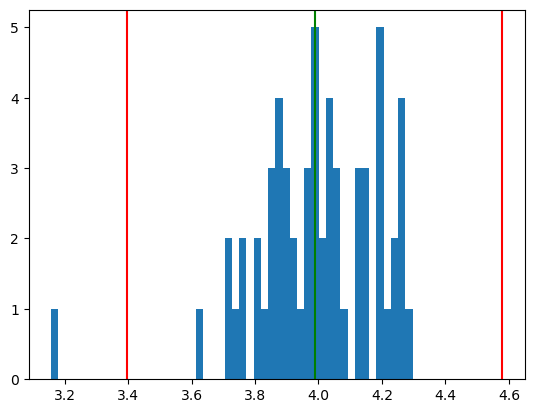

In [31]:
#The raw data needs to be filtered in order to clean the unmappable rows and columns, this kind of artifacts shows up in the distribution of reads per bin as outliers:

plt.figure()
norm = np.log10(np.sum(A + B, axis=0)[np.sum(A + B, axis=0) > 0])
norm = norm[np.isnan(norm) == False]
norm = norm[np.isinf(np.abs(norm)) == False]
plt.hist(norm, bins=50)
plt.axvline(x=np.median(norm), color='g')
plt.axvline(x=np.median(norm) - 3 * 1.4826 * sp.mad(norm), color='r')
plt.axvline(x=np.median(norm) + 3 * 1.4826 * sp.mad(norm), color='r')

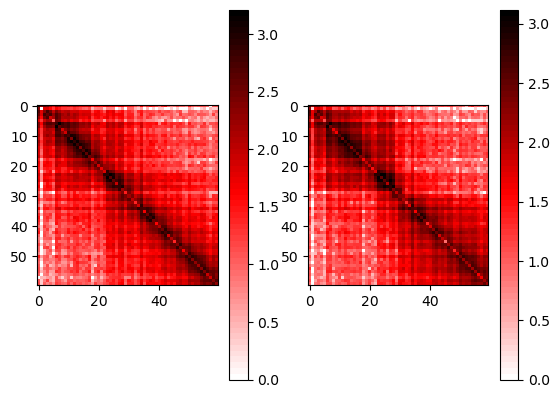

In [32]:
#flt = sp.outstanding_filter(A) + sp.outstanding_filter(B)
#flt = flt == False
#A = sp.fltmatr(A, flt)
#B = sp.fltmatr(B, flt)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1); sp.mshow(A, subplot=ax1)
ax2 = fig.add_subplot(1, 2, 2); sp.mshow(B, subplot=ax2)

Serpenting binning the data

Finally you can use the function to bin the data. The function takes two parameters: a threshold that constrains the coverage of the bin in at least one matrix, and the minthreshold that constrain it in both. The function uses multiple processors and can be configured by the optional parameters:

-0.25114484574132695 49.999999999999986
Starting 50 binning processes in batches of 4...
0	 Total serpentines: 3600 (100.0 %)0	 Total serpentines: 3600 (100.0 %)

0	 Total serpentines: 3600 (100.0 %)0	 Total serpentines: 3600 (100.0 %)

1	 Total serpentines: 2929 (81.36111111111111 %)1	 Total serpentines: 2913 (80.91666666666667 %)

1	 Total serpentines: 2907 (80.75 %)
1	 Total serpentines: 2916 (81.0 %)2	 Total serpentines: 2136 (59.333333333333336 %)

2	 Total serpentines: 2142 (59.5 %)
2	 Total serpentines: 2134 (59.27777777777778 %)3	 Total serpentines: 2026 (56.27777777777778 %)

2	 Total serpentines: 2136 (59.333333333333336 %)3	 Total serpentines: 2019 (56.083333333333336 %)

4	 Total serpentines: 2018 (56.05555555555556 %)3	 Total serpentines: 2016 (56.0 %)4	 Total serpentines: 2013 (55.916666666666664 %)
3	 Total serpentines: 2015 (55.97222222222222 %)
4	 Over: 2024-06-19 16:10:27.768797

4	 Over: 2024-06-19 16:10:27.770928

4	 Total serpentines: 2008 (55.77777777777778 %)
4	 

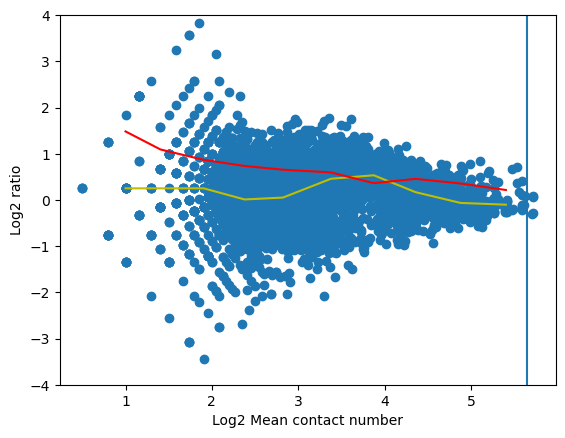

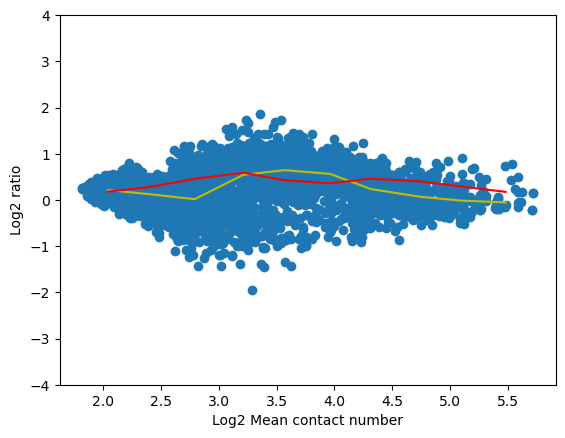

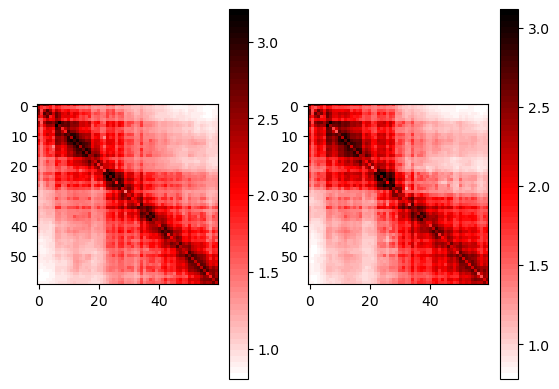

In [33]:
high=50
low=10
cycles = 50
plt.figure()
trend, threshold = sp.MDbefore(A, B, ylim=[-4, 4])
print(trend, threshold)

from scipy.ndimage import gaussian_filter
sA, sB, sK = sp.serpentin_binning(A, B, high, low, cycles)

#check binning quality
plt.figure()
sp.MDafter(sA, sB, sK, ylim=[-4, 4])

#check matrices
fig = plt.figure();
ax1 = fig.add_subplot(1, 2, 1)
sp.mshow(sA, subplot=ax1)
ax2 = fig.add_subplot(1, 2, 2)
sp.mshow(sB, subplot=ax2)

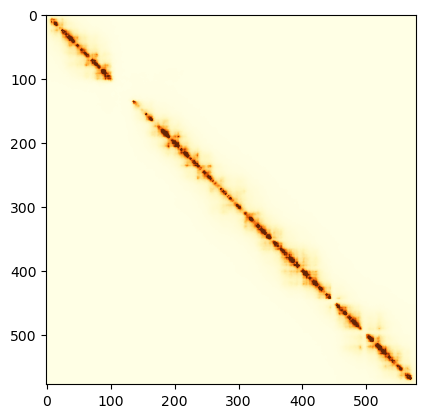

In [8]:
#plot individual matrices serpentinized
mini=0
maxi=25
suffix = str("_" + str(chrom) + "_serp_bin_low_" + str(int(low)) + "_max_" + str(int(high)) + "_colorscale_min_" + str(mini) + "_max_" + str(maxi) + ".pdf")

plt.imshow(sA, cmap = "YlOrBr", vmin=mini, vmax=maxi)
plt.savefig(str(out_dir + inputA + suffix), format='pdf', dpi=600)
plt.imshow(sB, cmap = "YlOrBr", vmin=mini, vmax=maxi)
plt.savefig(str(out_dir + inputB + suffix), format='pdf', dpi=600)

Checking the differential analysis

Similarly, we improved the differential analysis, before the binning, we could have obtained this kind of results:
Before binning:

In [9]:
plt.figure()
np.warnings.filterwarnings('ignore')
D = np.log2(B/A)
sp.dshow(D, trend, cmap= "bwr")

AttributeError: module 'numpy' has no attribute 'warnings'

<Figure size 640x480 with 0 Axes>

AD24_AD95_AD96_AD97_AD161_AD392to400_merged_S288c_DSB_chr3_rDNA_cutsite_q20 over AD182_S288c_DSB_chr3_rDNA_cutsite_q20
-0.08370674014035707 -0.25114484574132695


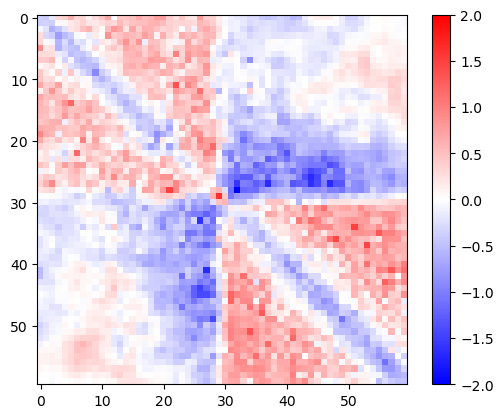

In [37]:
lim = 2
tr = np.mean(sK)
print(str(inputB), "over", str(inputA))
sp.dshow(sK, tr, cmap="bwr", limit = lim)
#str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chrom + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_bwr_trend_mean_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_bwr_trend_mean_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)
print(np.mean(sK), trend)

AD182_S288c_DSB_chr3_rDNA_cutsite_q20 over AD24_AD95_AD96_AD97_AD161_AD392to400_merged_S288c_DSB_chr3_rDNA_cutsite_q20
-0.08370674014035707 -0.25114484574132695


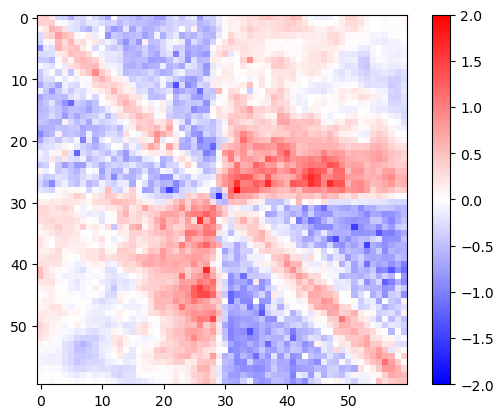

In [36]:
#after binning reverse
lim = 2
tr = np.mean(sK)
print(str(inputA), "over", str(inputB))
sp.dshow(-sK, -tr, cmap="bwr", limit = lim)
str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chrom + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputA + "over" + inputB + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputA + "over" + inputB + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)
print(np.mean(sK), trend)

AD24_AD95_AD96_AD97_AD161_AD392to400_merged_S288c_DSB_chr3_rDNA_cutsite_q20 over AD182_S288c_DSB_chr3_rDNA_cutsite_q20


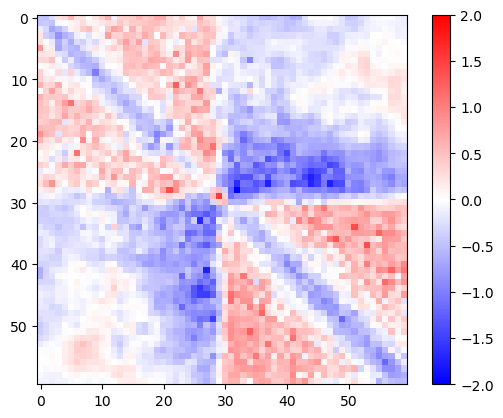

In [38]:
lim = 2
tr = 0
print(str(inputB), "over", str(inputA))
sp.dshow(sK, tr, cmap="bwr", limit = lim)
#str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chr + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)

AD182_S288c_DSB_chr3_rDNA_cutsite_q20 over AD24_AD95_AD96_AD97_AD161_AD392to400_merged_S288c_DSB_chr3_rDNA_cutsite_q20


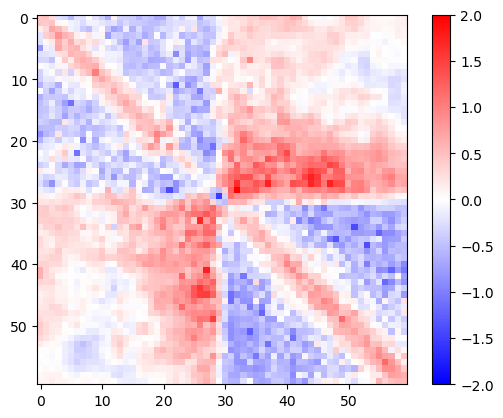

In [39]:
lim = 2
tr = 0
print(str(inputA), "over", str(inputB))
sp.dshow(-sK, -tr, cmap="bwr", limit = lim)
#str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chr + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputA + "over" + inputB + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)

0.05577278750043419
AD573_S288c_DSB_LY_Capture_artificial_v8_cutsite_q20_PCRfree over AD240_S288c_DSB_LY_Capture_artificial_v8_cutsite_q20_PCRfree


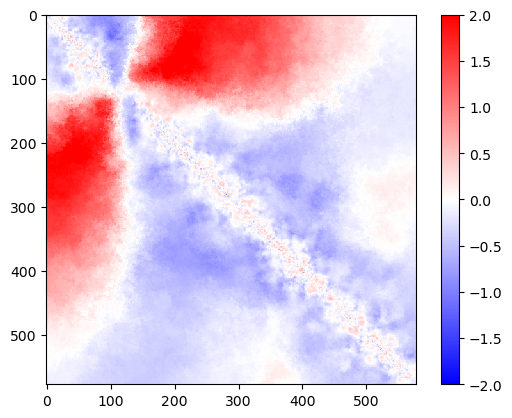

In [14]:
#after binning
lim = 2
tr = trend
print(tr)
print(str(inputB), "over", str(inputA))
sp.dshow(sK, tr, cmap="bwr", limit = lim)
#str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chrom + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + str(chrom) + "_1kb_bwr_default_trend_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + str(chrom) + "_1kb_bwr_default_trend_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)

AD240_S288c_DSB_LY_Capture_artificial_v8_cutsite_q20_PCRfree over AD573_S288c_DSB_LY_Capture_artificial_v8_cutsite_q20_PCRfree


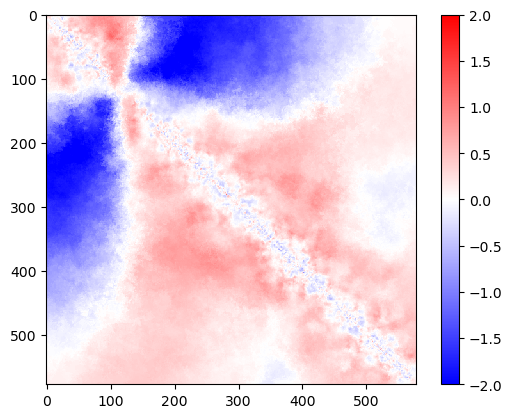

In [15]:
#after binning reverse
lim = 2
tr = trend
print(str(inputA), "over", str(inputB))
sp.dshow(-sK, -tr, cmap="bwr", limit = lim)
str("/mnt/d/OwnCloud Data/Experiments/HiC/Contact_files/Dense/" + inputB + "_" + chrom + "_dense_1kb.mat.csv")
plt.savefig(str(out_dir + inputA + "over" + inputB + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + "_low_" + str(low) + "_high_" + str(high) + ".pdf"), format='pdf', dpi=600)
#plt.savefig(str(out_dir + inputA + "over" + inputB + "_" + chrom + "_1kb_bwr_trend_" + str(tr) + "_lim_" + str(lim) + ".png"), dpi=600)